     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Processing PDF files:   0%|          | 0/15 [00:00<?, ?it/s]

Processing report from 2024: /content/drive/MyDrive/Amnesty_Reports/2024.pdf
Processing report from 2023: /content/drive/MyDrive/Amnesty_Reports/2023.pdf
Processing report from 2022: /content/drive/MyDrive/Amnesty_Reports/2022.pdf
Processing report from 2021: /content/drive/MyDrive/Amnesty_Reports/2021.pdf
Processing report from 2019: /content/drive/MyDrive/Amnesty_Reports/2019Americas.pdf
Processing report from 2019: /content/drive/MyDrive/Amnesty_Reports/2019Africa.pdf
Processing report from 2019: /content/drive/MyDrive/Amnesty_Reports/2019AsiaPacific.pdf
Processing report from 2019: /content/drive/MyDrive/Amnesty_Reports/2019EastEuropeCenAsia.pdf
Processing report from 2019: /content/drive/MyDrive/Amnesty_Reports/2019MidEastNorthAfr.pdf
Processing report from 2019: /content/drive/MyDrive/Amnesty_Reports/2019Europe.pdf
Processing report from 2018: /content/drive/MyDrive/Amnesty_Reports/2018.pdf
Processing report from 2017: /content/drive/MyDrive/Amnesty_Reports/2017.pdf
Processing re

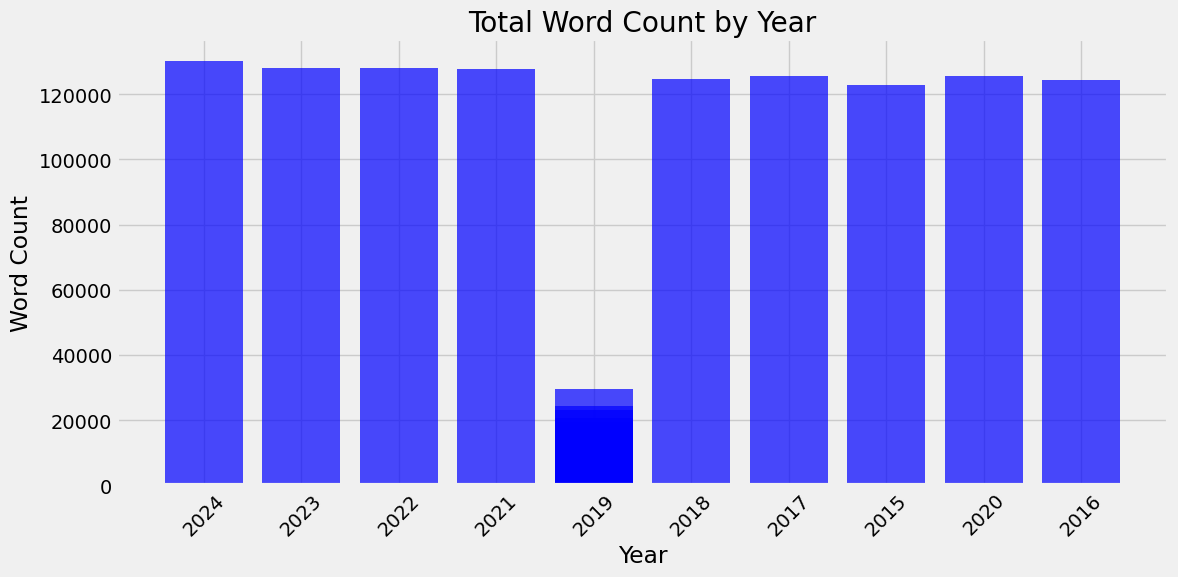

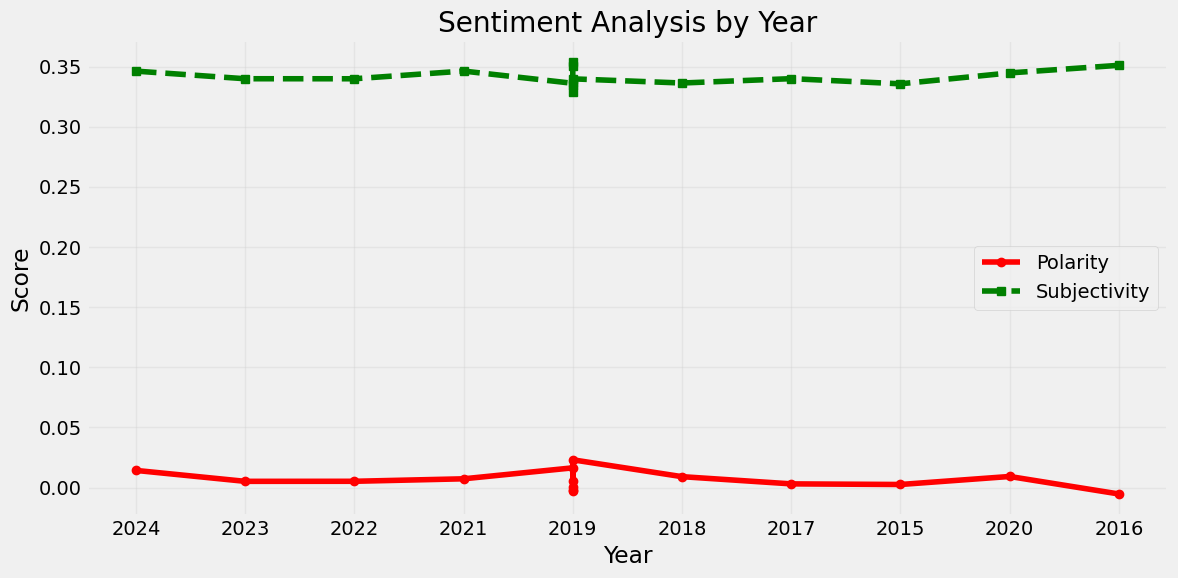

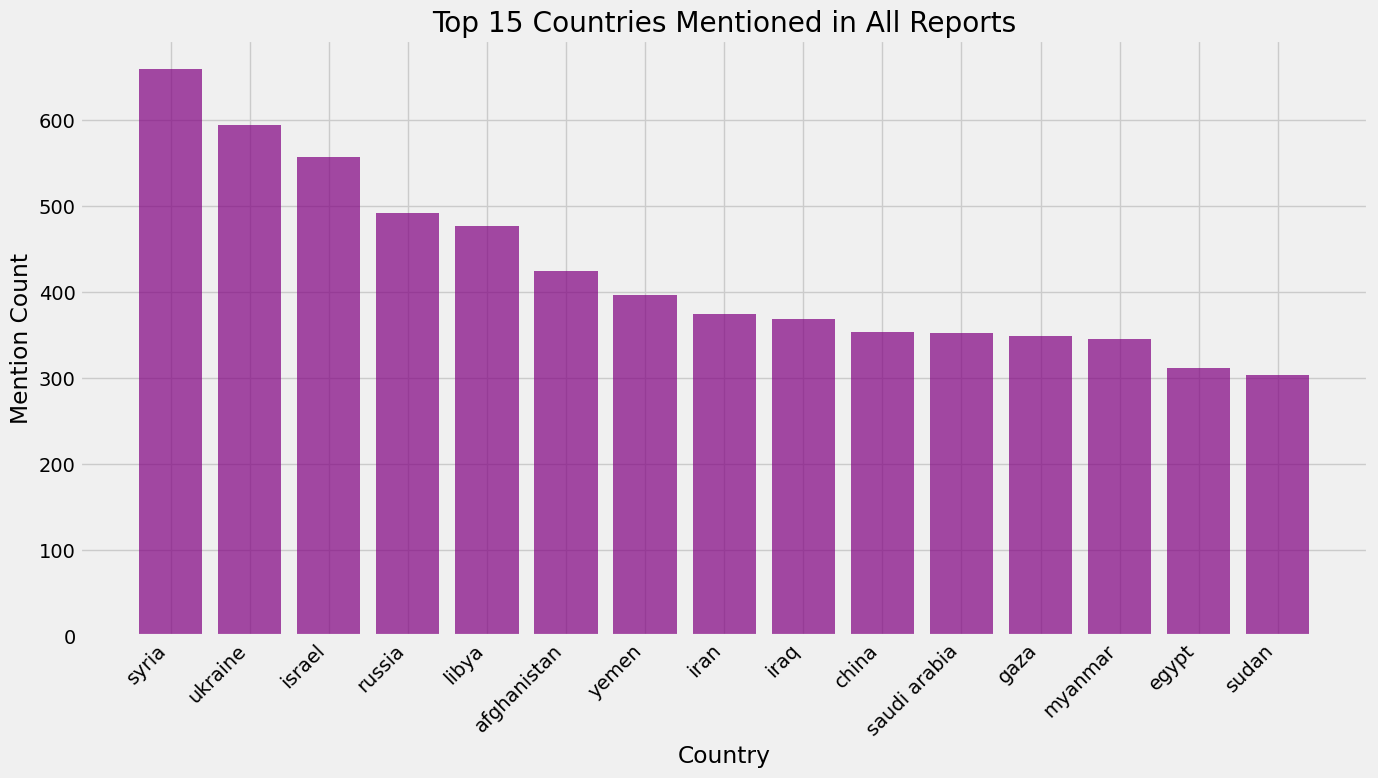

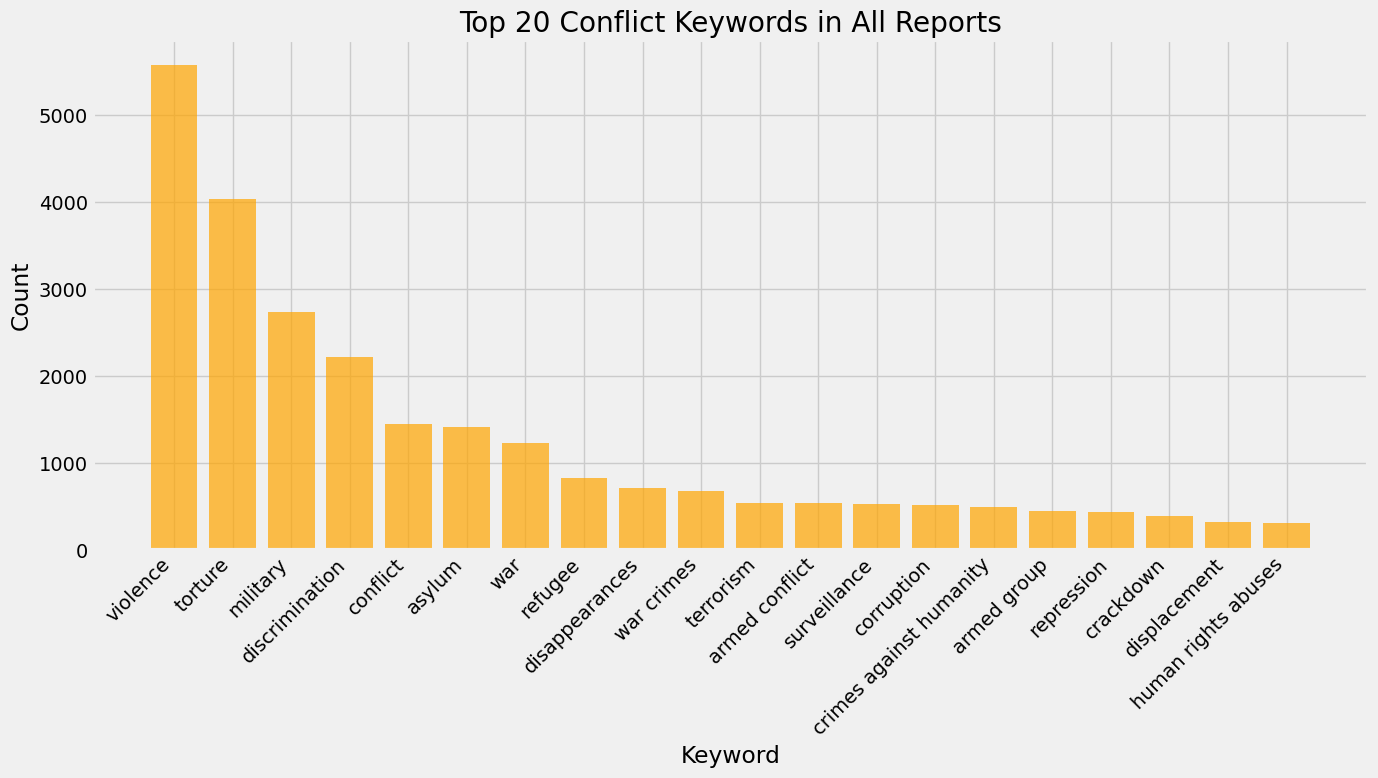

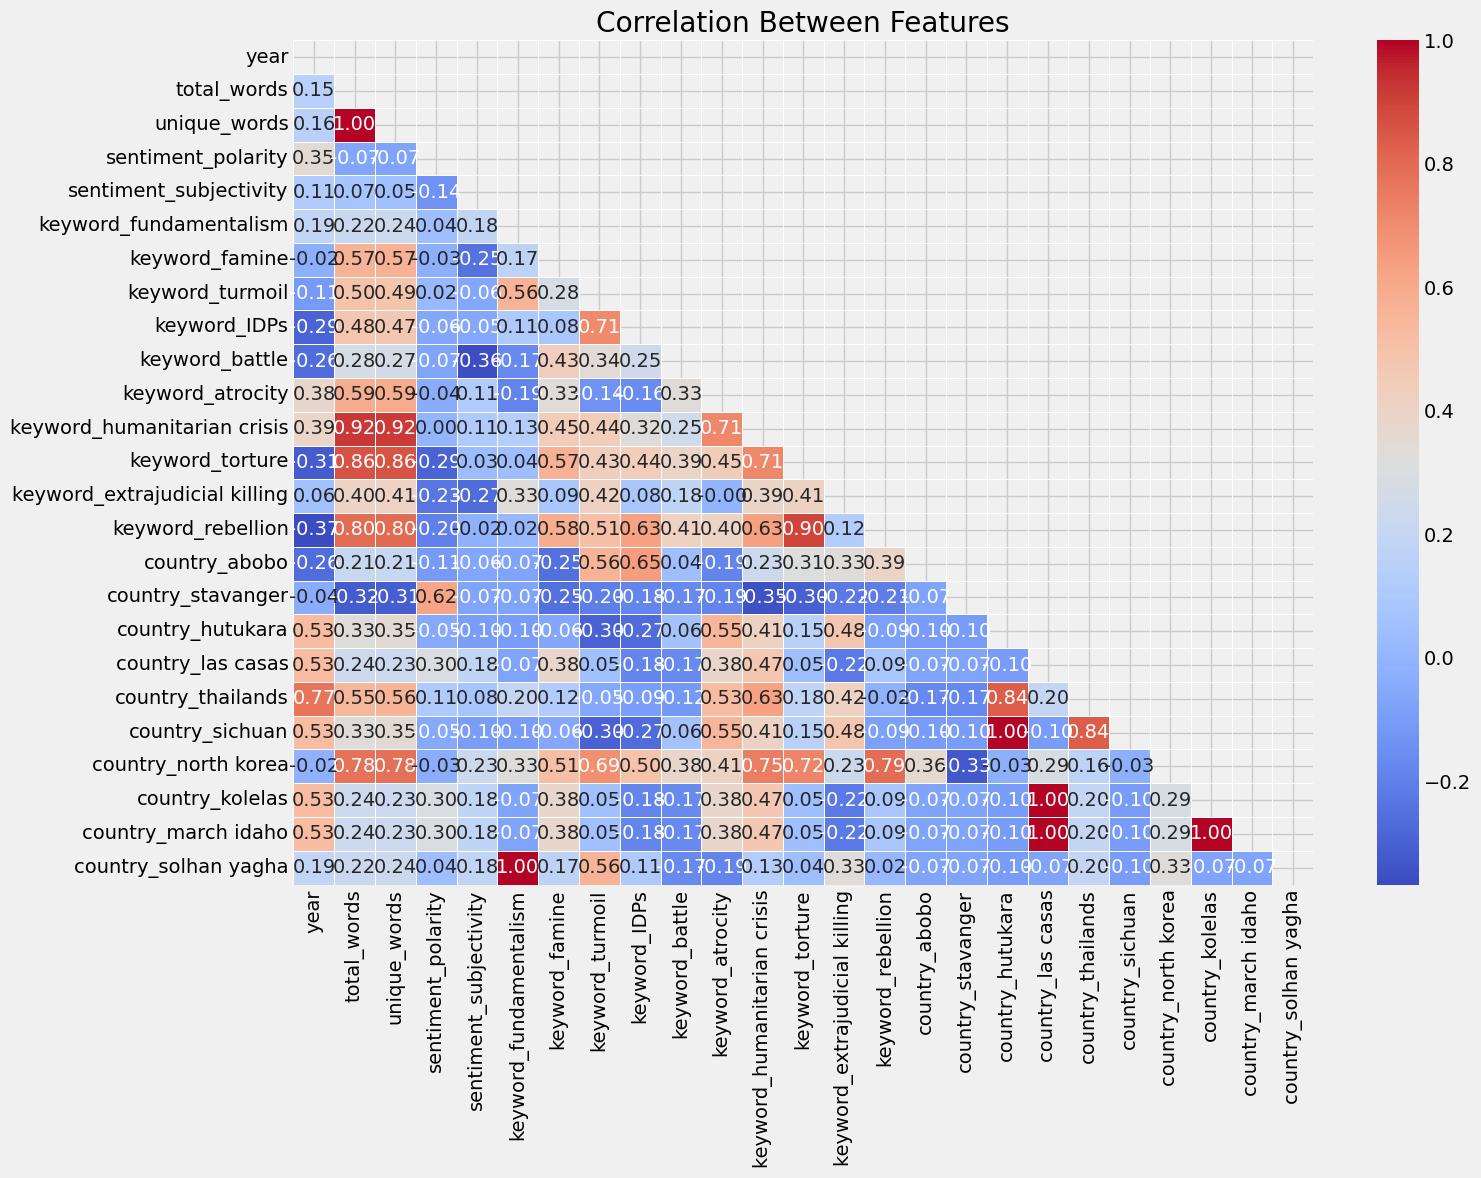

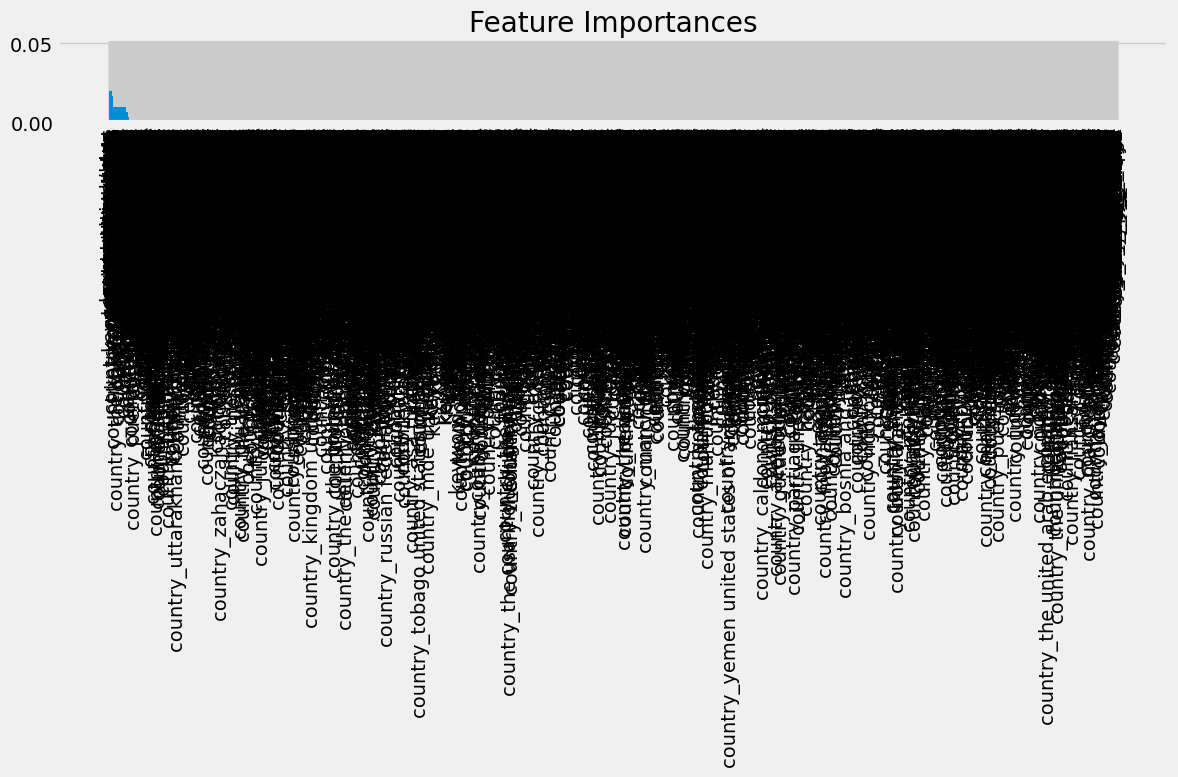

In [ ]:
# Human Rights Watch Reports - PDF Scraping and Preprocessing
# For conflict prediction model based on Amnesty reports from 2015-2025

# Install required libraries
!pip install PyPDF2 spacy gensim scikit-learn transformers torch pandas matplotlib seaborn wordcloud textblob tqdm

# Import necessary libraries
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm

# PDF processing
import PyPDF2

# NLP libraries
import spacy
from textblob import TextBlob

# Load spaCy model (medium sized model for better entity recognition)
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

# Set up a directory to store the processed data
!mkdir -p processed_data

# Function to extract text from PDF files
def extract_text_from_pdf(pdf_path):
    """
    Extract text from a PDF file.

    Args:
        pdf_path: Path to the PDF file

    Returns:
        str: Extracted text from the PDF
    """
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
    return text

# Function to clean and preprocess text
def preprocess_text(text):
    """
    Clean and preprocess the text from PDF.

    Args:
        text: Raw text extracted from PDF

    Returns:
        str: Cleaned and preprocessed text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove numbers and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Function to process text with spaCy
def process_with_spacy(text, max_length=1000000):
    """
    Process text with spaCy for tokenization, lemmatization, and entity extraction.
    Handles large texts by processing in chunks to avoid memory issues.

    Args:
        text: Text to process
        max_length: Maximum length of text to process at once

    Returns:
        tuple: (tokens, lemmas, entities)
    """
    tokens = []
    lemmas = []
    entities = {}

    # Process text in chunks if it's large
    if len(text) > max_length:
        chunks = [text[i:i+max_length] for i in range(0, len(text), max_length)]
    else:
        chunks = [text]

    for chunk in chunks:
        doc = nlp(chunk)

        # Extract tokens and lemmas
        for token in doc:
            # Skip stop words and short tokens
            if not token.is_stop and len(token.text) > 2:
                tokens.append(token.text)
                lemmas.append(token.lemma_)

        # Extract entities
        for ent in doc.ents:
            if ent.label_ not in entities:
                entities[ent.label_] = []
            entities[ent.label_].append(ent.text)

    return tokens, lemmas, entities

# Function to extract country-specific mentions
def extract_country_mentions(entities):
    """
    Extract country mentions from the entities.

    Args:
        entities: Dictionary of entities from spaCy

    Returns:
        dict: Dictionary with countries as keys and counts as values
    """
    # Extract country mentions (GPE = Geopolitical Entity)
    countries = []
    if 'GPE' in entities:
        countries = [country.lower() for country in entities['GPE']]

    country_counts = Counter(countries)
    return dict(country_counts)

# Function to perform sentiment analysis
def analyze_sentiment(text, chunk_size=5000):
    """
    Perform sentiment analysis on the text using TextBlob.
    Processes text in chunks for better performance with large texts.

    Args:
        text: Preprocessed text
        chunk_size: Size of chunks to process

    Returns:
        dict: Dictionary with sentiment scores
    """
    # Split text into sentences (approximate method)
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    polarity_scores = []
    subjectivity_scores = []

    # Process in chunks to handle large texts
    for i in range(0, len(sentences), chunk_size):
        chunk = " ".join(sentences[i:i+chunk_size])
        blob = TextBlob(chunk)
        polarity_scores.append(blob.sentiment.polarity)
        subjectivity_scores.append(blob.sentiment.subjectivity)

    # Calculate average sentiment
    avg_polarity = np.mean(polarity_scores) if polarity_scores else 0
    avg_subjectivity = np.mean(subjectivity_scores) if subjectivity_scores else 0

    sentiment = {
        'polarity': avg_polarity,
        'subjectivity': avg_subjectivity
    }

    return sentiment

# Function to identify conflict-related keywords
def identify_conflict_keywords(text, conflict_keywords=None):
    """
    Identify conflict-related keywords in the text.

    Args:
        text: Preprocessed text
        conflict_keywords: List of conflict-related keywords

    Returns:
        dict: Dictionary with conflict keywords as keys and counts as values
    """
    if conflict_keywords is None:
        # Default conflict-related keywords
        conflict_keywords = [
        # General Conflict Terms
    "conflict", "war", "violence", "clash", "unrest", "hostility", "insurgency", "uprising", "turmoil", "rebellion",
    "riot", "chaos", "combat", "fighting", "military", "warfare", "skirmish", "confrontation", "aggression",
    "armed conflict", "battle", "civil war", "sectarian violence", "terrorism", "extremism", "radicalization",

    # Political Instability & Governance Issues
    "coup", "authoritarianism", "dictatorship", "regime", "crackdown", "suppression", "oppression", "corruption",
    "sanctions", "martial law", "repression", "autocracy", "state violence", "political prisoners", "dissident",
    "government collapse", "failed state", "instability", "power struggle", "human rights abuses", "surveillance",
    "police brutality", "extrajudicial killing",

    # Ethnic, Religious, and Sectarian Conflict
    "ethnic cleansing", "genocide", "sectarian", "ethnic violence", "religious persecution", "massacre",
    "pogrom", "xenophobia", "hate crime", "discrimination", "racial violence", "forced displacement",

    # Humanitarian Crises & War Crimes
    "refugee", "displacement", "asylum", "forced migration", "internally displaced persons", "IDPs",
    "famine", "blockade", "humanitarian crisis", "siege", "war crimes", "crimes against humanity", "atrocity",
    "ethnic persecution", "rape as a weapon of war", "child soldiers", "torture", "execution", "disappearances",
    "chemical weapons", "biological weapons", "cluster munitions", "landmines", "indiscriminate attacks",

    # Terrorism & Insurgency
    "terrorist", "suicide bombing", "extremist", "radical group", "paramilitary", "guerrilla warfare",
    "fundamentalism", "insurgent", "armed group", "warlord", "militant", "jihad", "proxy war",

    # Military Operations & Foreign Interventions
    "airstrike", "bombing", "drone strike", "invasion", "occupation", "military intervention", "proxy conflict",
    "foreign interference", "sanctions", "arms trade", "weapons proliferation",
        ]

    # Count occurrences of conflict keywords
    conflict_counts = {}

    for keyword in conflict_keywords:
        if ' ' in keyword:  # Multi-word keyword
            pattern = r'\b' + re.escape(keyword) + r'\b'
            keyword_count = len(re.findall(pattern, text, re.IGNORECASE))
        else:  # Single-word keyword
            pattern = r'\b' + re.escape(keyword) + r'\b'
            keyword_count = len(re.findall(pattern, text, re.IGNORECASE))

        if keyword_count > 0:
            conflict_counts[keyword] = keyword_count

    return conflict_counts

# Main function to process all PDF files
def process_amnesty_reports(pdf_directory):
    """
    Process all Amnesty PDF reports in the specified directory.

    Args:
        pdf_directory: Directory containing PDF files

    Returns:
        pd.DataFrame: DataFrame with processed data
    """
    # Get all PDF files in the directory
    pdf_files = glob.glob(os.path.join(pdf_directory, '*.pdf'))

    # Create a list to store processed data
    processed_data = []

    for pdf_file in tqdm(pdf_files, desc="Processing PDF files"):
        # Extract year from filename or path
        try:
            year = re.search(r'(\d{4})', os.path.basename(pdf_file)).group(1)
        except:
            # If year is not in filename, use the current date
            year = datetime.now().year

        print(f"Processing report from {year}: {pdf_file}")

        # Extract text from PDF
        text = extract_text_from_pdf(pdf_file)

        # Save raw text
        with open(f"processed_data/raw_{year}.txt", 'w', encoding='utf-8') as f:
            f.write(text)

        # Preprocess text
        preprocessed_text = preprocess_text(text)

        # Process with spaCy
        tokens, lemmas, entities = process_with_spacy(preprocessed_text)

        # Save preprocessed tokens
        with open(f"processed_data/tokens_{year}.txt", 'w', encoding='utf-8') as f:
            f.write(' '.join(tokens))

        # Extract country mentions
        country_mentions = extract_country_mentions(entities)

        # Perform sentiment analysis
        sentiment = analyze_sentiment(preprocessed_text)

        # Identify conflict keywords
        conflict_keywords = identify_conflict_keywords(preprocessed_text)

        # Calculate basic statistics
        total_words = len(tokens)
        unique_words = len(set(tokens))

        # Store processed data
        report_data = {
            'year': year,
            'filename': os.path.basename(pdf_file),
            'total_words': total_words,
            'unique_words': unique_words,
            'tokens': tokens[:10000],  # Limit tokens to save memory
            'lemmas': lemmas[:10000],  # Limit lemmas to save memory
            'entities': entities,
            'country_mentions': country_mentions,
            'sentiment_polarity': sentiment['polarity'],
            'sentiment_subjectivity': sentiment['subjectivity'],
            'conflict_keywords': conflict_keywords
        }

        processed_data.append(report_data)

    # Create DataFrame
    df = pd.DataFrame(processed_data)

    # Save DataFrame
    df.to_pickle("processed_data/amnesty_reports_processed.pkl")

    return df

# Function to visualize the processed data
def visualize_data(df):
    """
    Visualize the processed data.

    Args:
        df: DataFrame with processed data
    """
    # Set up the plotting style
    plt.style.use('fivethirtyeight')

    # 1. Create a figure for word count over years
    plt.figure(figsize=(12, 6))
    plt.bar(df['year'], df['total_words'], color='blue', alpha=0.7)
    plt.title('Total Word Count by Year')
    plt.xlabel('Year')
    plt.ylabel('Word Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('processed_data/word_count_by_year.png')

    # 2. Create a figure for sentiment analysis
    plt.figure(figsize=(12, 6))
    plt.plot(df['year'], df['sentiment_polarity'], marker='o', linestyle='-', color='red', label='Polarity')
    plt.plot(df['year'], df['sentiment_subjectivity'], marker='s', linestyle='--', color='green', label='Subjectivity')
    plt.title('Sentiment Analysis by Year')
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('processed_data/sentiment_by_year.png')

    # 3. Visualize top countries mentioned (across all reports)
    all_countries = {}
    for country_dict in df['country_mentions']:
        for country, count in country_dict.items():
            if country in all_countries:
                all_countries[country] += count
            else:
                all_countries[country] = count

    # Sort and get top 15 countries
    top_countries = dict(sorted(all_countries.items(), key=lambda x: x[1], reverse=True)[:15])

    plt.figure(figsize=(14, 8))
    plt.bar(top_countries.keys(), top_countries.values(), color='purple', alpha=0.7)
    plt.title('Top 15 Countries Mentioned in All Reports')
    plt.xlabel('Country')
    plt.ylabel('Mention Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('processed_data/top_countries.png')

    # 4. Visualize conflict keywords (across all reports)
    all_keywords = {}
    for keyword_dict in df['conflict_keywords']:
        for keyword, count in keyword_dict.items():
            if keyword in all_keywords:
                all_keywords[keyword] += count
            else:
                all_keywords[keyword] = count

    # Sort and get top 20 keywords
    top_keywords = dict(sorted(all_keywords.items(), key=lambda x: x[1], reverse=True)[:20])

    plt.figure(figsize=(14, 8))
    plt.bar(top_keywords.keys(), top_keywords.values(), color='orange', alpha=0.7)
    plt.title('Top 20 Conflict Keywords in All Reports')
    plt.xlabel('Keyword')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('processed_data/top_conflict_keywords.png')

    # 5. Create a correlation heatmap
    # First, expand the conflict keywords and country mentions into columns
    all_conflict_keywords = set()
    all_countries = set()

    for conflict_dict in df['conflict_keywords']:
        all_conflict_keywords.update(conflict_dict.keys())

    for country_dict in df['country_mentions']:
        all_countries.update(country_dict.keys())

    # Create a new DataFrame with expanded columns
    expanded_df = pd.DataFrame(index=df.index)
    expanded_df['year'] = df['year']
    expanded_df['total_words'] = df['total_words']
    expanded_df['unique_words'] = df['unique_words']
    expanded_df['sentiment_polarity'] = df['sentiment_polarity']
    expanded_df['sentiment_subjectivity'] = df['sentiment_subjectivity']

    # Add conflict keyword columns
    for keyword in list(all_conflict_keywords)[:10]:  # Limit to top 10 for visualization
        expanded_df[f'keyword_{keyword}'] = df['conflict_keywords'].apply(
            lambda x: x.get(keyword, 0)
        )

    # Add country mention columns
    for country in list(all_countries)[:10]:  # Limit to top 10 for visualization
        expanded_df[f'country_{country}'] = df['country_mentions'].apply(
            lambda x: x.get(country, 0)
        )

    # Create correlation heatmap
    plt.figure(figsize=(16, 12))
    corr_matrix = expanded_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Between Features')
    plt.tight_layout()
    plt.savefig('processed_data/correlation_heatmap.png')

# Function to build feature matrix for ML model
def build_feature_matrix(df):
    """
    Build a feature matrix from the processed data for machine learning.

    Args:
        df: DataFrame with processed data

    Returns:
        pd.DataFrame: Feature matrix
    """
    # Create a set of all conflict keywords and countries
    all_conflict_keywords = set()
    all_countries = set()

    for conflict_dict in df['conflict_keywords']:
        all_conflict_keywords.update(conflict_dict.keys())

    for country_dict in df['country_mentions']:
        all_countries.update(country_dict.keys())

    # Create feature matrix
    features = []

    for _, row in df.iterrows():
        feature_dict = {
            'year': row['year'],
            'total_words': row['total_words'],
            'unique_words': row['unique_words'],
            'sentiment_polarity': row['sentiment_polarity'],
            'sentiment_subjectivity': row['sentiment_subjectivity'],
        }

        # Add conflict keyword features
        for keyword in all_conflict_keywords:
            feature_dict[f'keyword_{keyword}'] = row['conflict_keywords'].get(keyword, 0)

        # Add country mention features
        for country in all_countries:
            feature_dict[f'country_{country}'] = row['country_mentions'].get(country, 0)

        features.append(feature_dict)

    # Create feature matrix DataFrame
    feature_df = pd.DataFrame(features)

    # Save feature matrix
    feature_df.to_csv('processed_data/feature_matrix.csv', index=False)

    return feature_df

# Example usage in Google Colab

# 1. Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# 2. Define PDF directory (adjust path as needed)
pdf_directory = '/content/drive/MyDrive/Amnesty_Reports'

# 3. Process reports
df = process_amnesty_reports(pdf_directory)

# 4. Visualize data
visualize_data(df)

# 5. Build feature matrix for ML model
feature_df = build_feature_matrix(df)

# 6. Now you can build your conflict prediction model using the feature matrix
# For example:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# You'll need to define your target variable, e.g., based on conflict intensity levels
# This could be based on keyword counts, sentiment, or external conflict data
# For example:
feature_df['conflict_intensity'] = feature_df['keyword_war'] + feature_df['keyword_violence'] + feature_df['keyword_conflict']
feature_df['conflict_label'] = (feature_df['conflict_intensity'] > feature_df['conflict_intensity'].median()).astype(int)

# Then train a model
X = feature_df.drop(['year', 'conflict_intensity', 'conflict_label'], axis=1)
y = feature_df['conflict_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig('processed_data/feature_importance.png')